In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kimis13","key":"a520fe22f2314a69a8f94a464b80e566"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!mkdir /content/gdrive/My\ Drive/.kaggle/
!mv kaggle.json /content/gdrive/My\ Drive/.kaggle/
!chmod 600 /content/gdrive/My\ Drive/.kaggle/kaggle.json

mkdir: cannot create directory ‘/content/gdrive/My Drive/.kaggle/’: File exists


In [ ]:
! cp -r /content/gdrive/My\ Drive/.kaggle/ /root/

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 149M/149M [00:07<00:00, 19.7MB/s]
100% 149M/149M [00:07<00:00, 19.9MB/s]


In [ ]:
!mkdir /content/gdrive/My\ Drive/brain_tumor_mri_dataset
!mv brain-tumor-mri-dataset.zip /content/gdrive/My\ Drive/brain_tumor_mri_dataset
%cd /content/gdrive/My\ Drive/brain_tumor_mri_dataset


mkdir: cannot create directory ‘/content/gdrive/My Drive/brain_tumor_mri_dataset’: File exists
mv: cannot stat 'brain-tumor-mri-dataset.zip': No such file or directory
/content/gdrive/My Drive/brain_tumor_mri_dataset


In [ ]:
!pwd

/content/gdrive/My Drive/brain_tumor_mri_dataset


In [ ]:
!unzip brain-tumor-mri-dataset.zip

Archive:  brain-tumor-mri-dataset.zip
replace Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Testing/glioma/Te-glTr_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])
    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
train_path=train_df('/content/gdrive/My Drive/brain_tumor_mri_dataset/Training')
test_path=test_df('/content/gdrive/My Drive/brain_tumor_mri_dataset/Testing')

In [ ]:
train_path[:10]

,Class Path,Class
0,/content/gdrive/My Drive/brain_tumor_mri_datas...,glioma
1,/content/gdrive/My Drive/brain_tumor_mri_datas...,glioma
2,/content/gdrive/My Drive/brain_tumor_mri_datas...,glioma
3,/content/gdrive/My Drive/brain_tumor_mri_datas...,glioma
4,/content/gdrive/My Drive/brain_tumor_mri_datas...,glioma
5,/content/gdrive/My Drive/brain_tumor_mri_datas...,glioma
6,/content/gdrive/My Drive/brain_tumor_mri_datas...,glioma
7,/content/gdrive/My Drive/brain_tumor_mri_datas...,glioma
8,/content/gdrive/My Drive/brain_tumor_mri_datas...,glioma
9,/content/gdrive/My Drive/brain_tumor_mri_datas...,glioma


In [ ]:
train_set, valid_set=train_test_split(train_path, test_size=0.2, random_state=42, stratify=train_path['Class'])

In [ ]:
valid_set

,Class Path,Class
2170,/content/gdrive/My Drive/brain_tumor_mri_datas...,meningioma
5102,/content/gdrive/My Drive/brain_tumor_mri_datas...,pituitary
2600,/content/gdrive/My Drive/brain_tumor_mri_datas...,meningioma
4568,/content/gdrive/My Drive/brain_tumor_mri_datas...,pituitary
2864,/content/gdrive/My Drive/brain_tumor_mri_datas...,notumor
...,...,...
2742,/content/gdrive/My Drive/brain_tumor_mri_datas...,notumor
4394,/content/gdrive/My Drive/brain_tumor_mri_datas...,pituitary
5606,/content/gdrive/My Drive/brain_tumor_mri_datas...,pituitary
5681,/content/gdrive/My Drive/brain_tumor_mri_datas...,pituitary


In [ ]:
batch_size=32
img_size=(224,224)
_gen=ImageDataGenerator(rescale=1./255, brightness_range=(0.8,1.2))
test_gen=ImageDataGenerator(rescale=1./255)
train_gen=_gen.flow_from_dataframe(train_set, x_col='Class Path', y_col='Class', target_size=img_size, batch_size=batch_size)
valid_gen=_gen.flow_from_dataframe(valid_set, x_col='Class Path', y_col='Class', target_size=img_size, batch_size=batch_size)
test_gen=test_gen.flow_from_dataframe(test_path, x_col='Class Path', y_col='Class', target_size=img_size, batch_size=16, shuffle=False)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
img_shape=(224,224,3)
base_model=tf.keras.applications.Xception(input_shape=img_shape, include_top=False, weights='imagenet', pooling='max')
model=Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


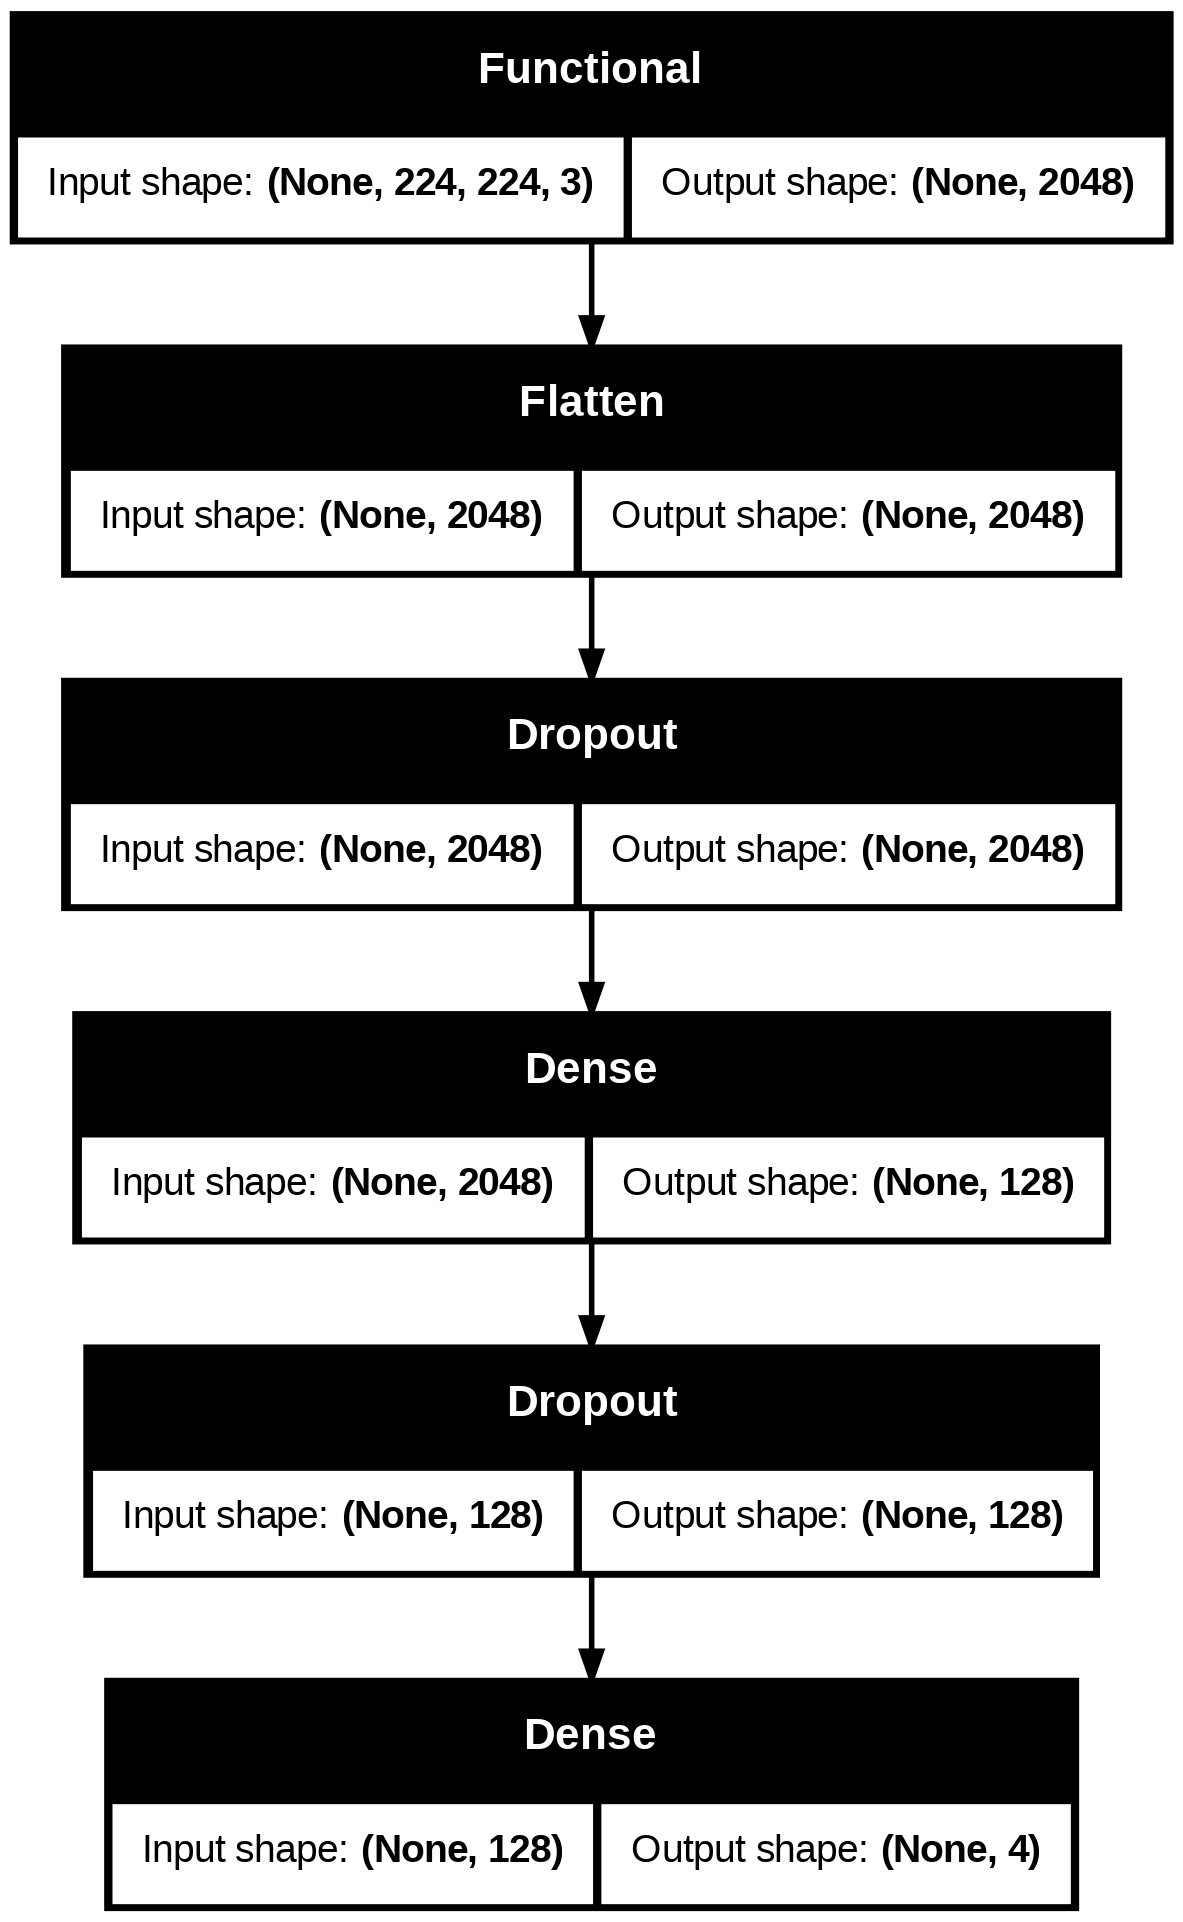

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adamax(), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [ ]:
train_model=model.fit(train_gen,
                      epochs=10,
                      validation_data=valid_gen,
                      shuffle=False)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 3026s 21s/step - accuracy: 0.7816 - loss: 0.6127 - precision: 0.8200 - recall: 0.7029 - val_accuracy: 0.8180 - val_loss: 0.7254 - val_precision: 0.8300 - val_recall: 0.8075
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 511ms/step - accuracy: 0.9752 - loss: 0.0795 - precision: 0.9768 - recall: 0.9733 - val_accuracy: 0.9291 - val_loss: 0.1653 - val_precision: 0.9340 - val_recall: 0.9283
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 508ms/step - accuracy: 0.9894 - loss: 0.0324 - precision: 0.9894 - recall: 0.9890 - val_accuracy: 0.9703 - val_loss: 0.0753 - val_precision: 0.9710 - val_recall: 0.9676
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 502ms/step - accuracy: 0.9913 - loss: 0.0208 - precision: 0.9916 - recall: 0.9913 - val_accuracy: 0.9851 - val_loss: 0.0525 - val_precision: 0.9860 - val_recall: 0.9834
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 499ms/step - accuracy: 0.9968 - loss: 0.0095 - precision: 0.9969 - recall: 0.9968 - val_accuracy: 0.9746 - val_loss

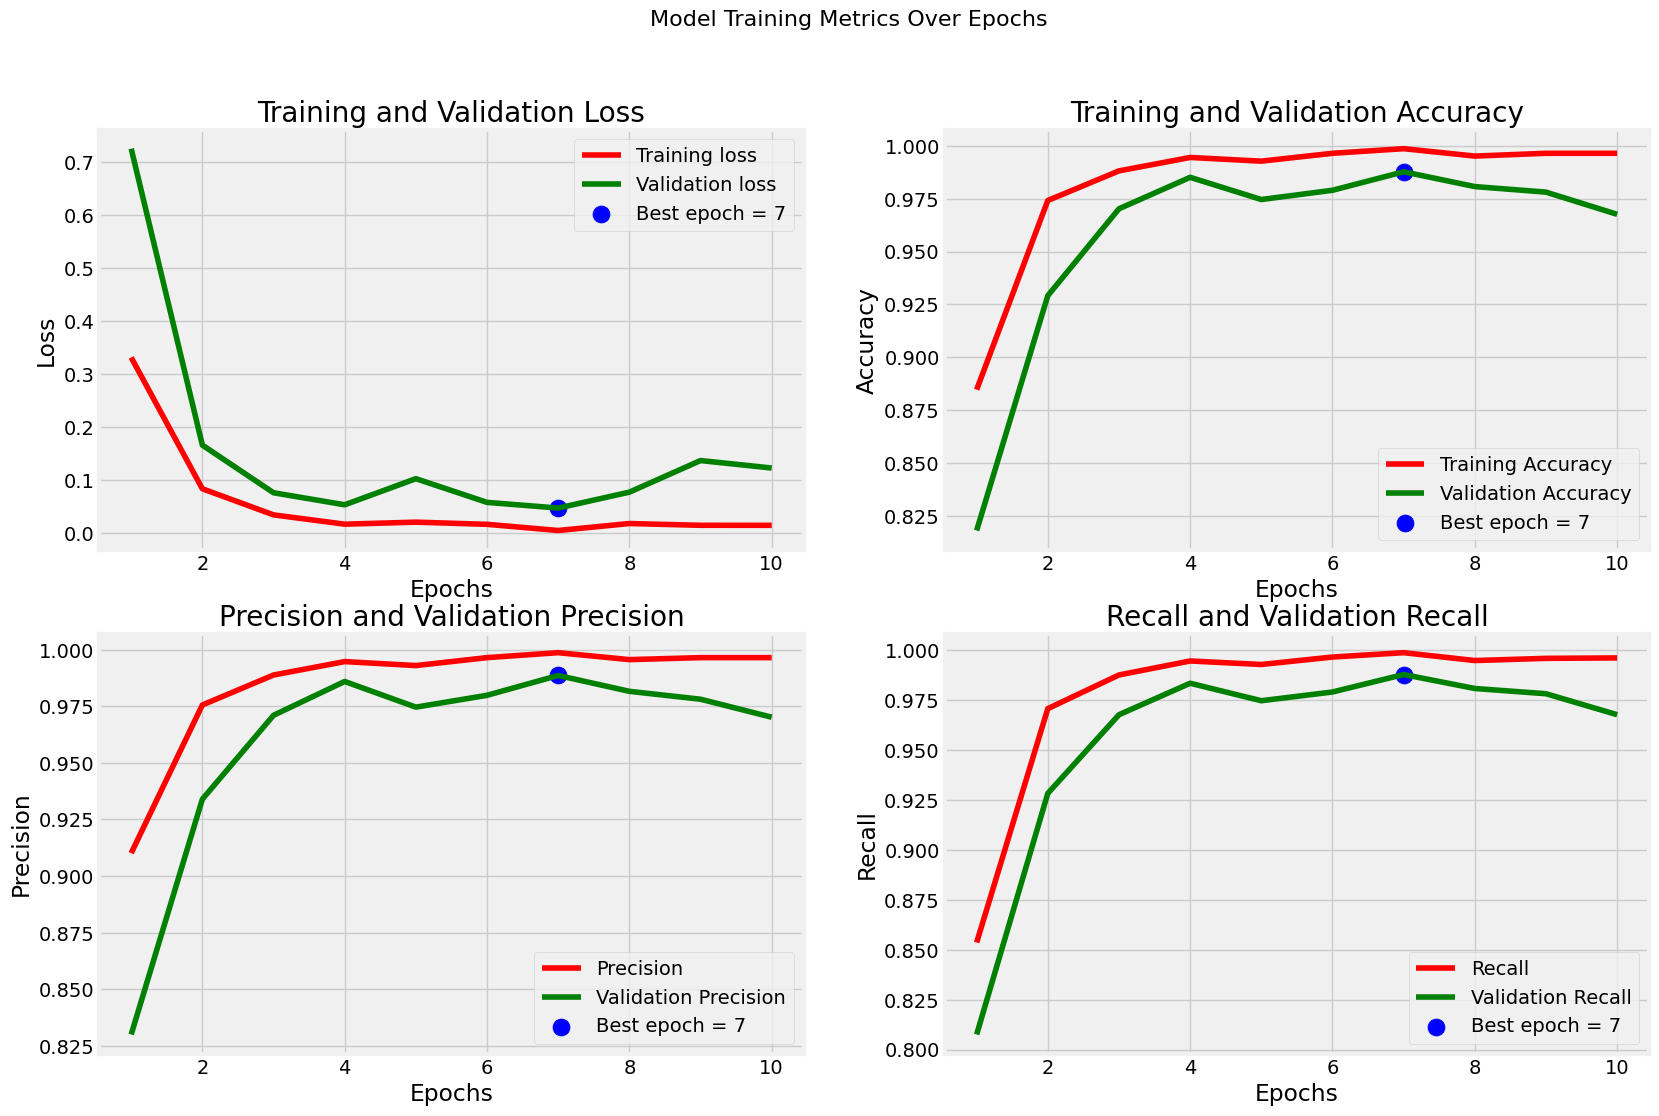

In [ ]:
tr_acc = train_model.history['accuracy']
tr_loss = train_model.history['loss']
tr_per = train_model.history['precision']
tr_recall = train_model.history['recall']
val_acc = train_model.history['val_accuracy']
val_loss = train_model.history['val_loss']
val_per = train_model.history['val_precision']
val_recall = train_model.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 231ms/step - accuracy: 0.9967 - loss: 0.0126 - precision: 0.9971 - recall: 0.9967
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.9682 - loss: 0.1318 - precision: 0.9681 - recall: 0.9650


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 871s 11s/step - accuracy: 0.9777 - loss: 0.0874 - precision: 0.9784 - recall: 0.9767
Train Loss: 0.0131
Train Accuracy: 99.65%
--------------------
Validation Loss: 0.1186
Validation Accuracy: 96.94%
--------------------
Test Loss: 0.0858
Test Accuracy: 97.71%


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step


In [ ]:
classes=test_gen.class_indices
classes

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

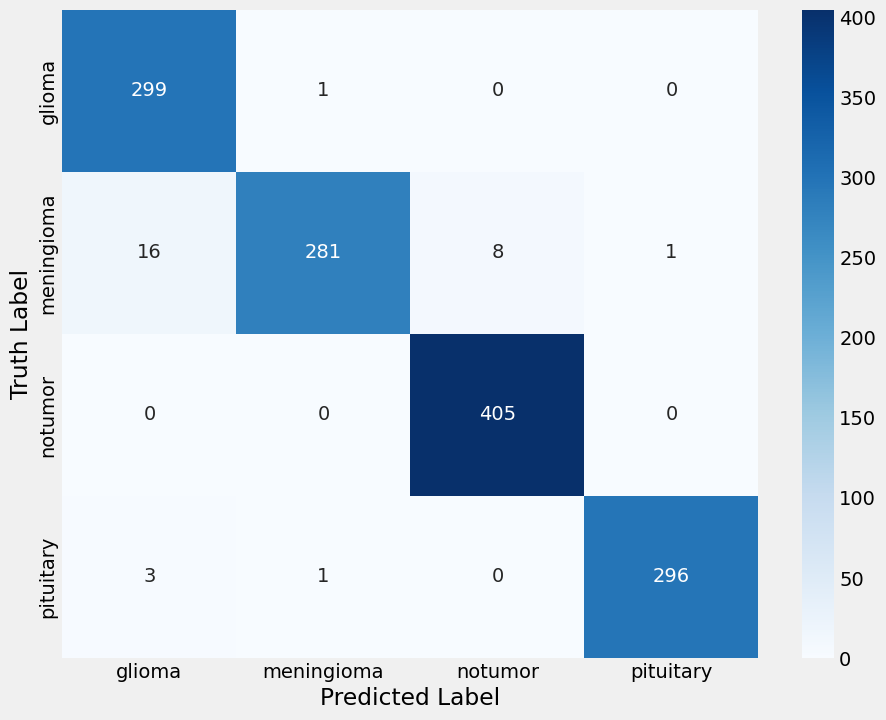

In [ ]:
cm = confusion_matrix(test_gen.classes, y_pred)
labels = list(classes.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
model.save('brain-tumor-xCeption.keras')